In [ ]:
!pip install category_encoders
!pip install catboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical
from catboost import CatBoostClassifier, Pool
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans

     |████████████████████████████████| 80 kB 3.8 MB/s 
     |████████████████████████████████| 67.4 MB 25 kB/s 


In [ ]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [ ]:
train.fillna('NaN', inplace=True) 
test.fillna('NaN', inplace=True)

In [ ]:
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

In [ ]:
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

In [ ]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

In [ ]:
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

In [ ]:
for df in [train,test]:
    # before_EMPLOYED: 고용되기 전까지의 일수
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)
    
    #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
    df['Age'] = df['DAYS_BIRTH'] // 365
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

    
    #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #ability: 소득/(살아온 일수+ 근무일수)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    
    #income_mean: 소득/ 가족 수
    df['income_mean'] = df['income_total'] / df['family_size']
    
    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)


In [ ]:
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED',]
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

In [ ]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  14
Number of Categorical features:  9


In [ ]:
numerical_feats

['work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month',
 'income_total_befofeEMP_ratio',
 'before_EMPLOYED_m',
 'before_EMPLOYED_w',
 'Age',
 'DAYS_BIRTH_m',
 'EMPLOYED',
 'DAYS_EMPLOYED_m',
 'ability',
 'income_mean']

In [ ]:
categorical_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'ID']

In [ ]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

In [ ]:
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

다중공선성 컬럼 추출

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X=train.copy()

In [ ]:
scaler.fit(X)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
vif_X_scaler = scaler.transform(X)

In [ ]:
vif_X_scaler 

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.80770438e-02, 1.04981848e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        1.45041784e-01, 8.39720317e-02, 1.14220445e-04],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.44843436e-01, 2.43646632e-01, 2.28440891e-04],
       ...,
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        1.85696876e-01, 1.55405405e-01, 9.99771559e-01],
       [1.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        1.24996914e-01, 1.83138362e-01, 9.99885780e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.18522630e-02, 3.69100444e-02, 1.00000000e+00]])

In [ ]:
vif_X = pd.DataFrame(vif_X_scaler, columns=X.columns)

In [ ]:
vif_X 

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,family_size,begin_month,credit,before_EMPLOYED,income_total_befofeEMP_ratio,before_EMPLOYED_m,before_EMPLOYED_w,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w,ability,income_mean,ID
0,0.0,0.0,0.0,0.495521,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.166667,0.100000,0.5,0.142059,0.101664,0.545455,0.000000,0.361702,0.636364,0.333333,0.279070,0.000000,0.000000,0.078077,0.104982,0.000000
1,0.0,0.0,1.0,0.544873,0.00,0.25,0.25,0.2,0.0,0.0,1.0,0.055556,0.333333,0.083333,0.5,0.176995,0.116927,0.363636,0.333333,0.212766,0.636364,0.333333,0.093023,0.272727,0.000000,0.145042,0.083972,0.000114
2,1.0,1.0,1.0,0.691901,0.25,0.00,0.00,0.2,0.0,1.0,0.0,0.111111,0.166667,0.366667,1.0,0.435689,0.144137,0.727273,0.333333,0.659574,0.000000,0.666667,0.279070,0.272727,0.333333,0.144843,0.243647,0.000228
3,0.0,0.0,1.0,0.495521,0.00,0.25,0.00,0.2,0.0,1.0,0.0,0.166667,0.166667,0.616667,0.0,0.346627,0.070072,0.090909,0.000000,0.425532,0.909091,1.000000,0.116279,0.818182,0.666667,0.085398,0.104982,0.000343
4,0.0,1.0,1.0,0.433715,0.50,0.00,0.00,0.2,0.0,0.0,0.0,0.111111,0.166667,0.433333,1.0,0.343187,0.053414,1.000000,1.000000,0.425532,0.818182,0.000000,0.116279,0.909091,0.000000,0.064363,0.079770,0.000457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26446,0.0,0.0,0.0,0.521433,0.50,0.25,0.00,0.2,0.0,0.0,0.0,0.277778,0.500000,0.033333,0.5,0.190701,0.102905,0.000000,0.666667,0.255319,0.545455,0.333333,0.116279,0.545455,1.000000,0.119491,0.054558,0.376927
26447,0.0,0.0,1.0,0.466554,0.25,0.00,0.50,0.2,0.0,0.0,0.0,0.000000,0.166667,0.783333,1.0,0.336952,0.062549,0.636364,0.666667,0.425532,0.454545,0.000000,0.139535,0.909091,0.333333,0.072001,0.092376,0.999657
26448,0.0,1.0,0.0,0.585957,0.25,0.25,0.25,0.4,0.0,0.0,0.0,0.277778,0.166667,0.416667,1.0,0.081698,0.171299,0.363636,0.000000,0.127660,0.000000,0.000000,0.116279,0.636364,1.000000,0.185697,0.155405,0.999772
26449,1.0,0.0,1.0,0.453940,0.25,0.50,0.75,0.2,0.0,0.0,0.0,0.055556,0.000000,0.983333,1.0,0.187638,0.077188,0.909091,0.666667,0.127660,0.181818,0.333333,0.000000,0.272727,1.000000,0.124997,0.183138,0.999886


In [ ]:
vif=pd.DataFrame()
vif

""


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
vif_X.values

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.80770438e-02, 1.04981848e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        1.45041784e-01, 8.39720317e-02, 1.14220445e-04],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.44843436e-01, 2.43646632e-01, 2.28440891e-04],
       ...,
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        1.85696876e-01, 1.55405405e-01, 9.99771559e-01],
       [1.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        1.24996914e-01, 1.83138362e-01, 9.99885780e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.18522630e-02, 3.69100444e-02, 1.00000000e+00]])

In [ ]:
# vif_X 의 0 번째 컬럼 (gender) 의 다중 공선성 지수를 계산
# 다중 공선성 지수가 10 초과이면 다른 독립변수와 연관 관계가 큰 컬럼
variance_inflation_factor(vif_X.values, 0) 

1.8719988935297758

In [ ]:
variance_inflation_factor(vif_X.values, 1) 

1.9670061595496215

In [ ]:
variance_inflation_factor(vif_X.values, 2) 

3.2625728397947333

In [ ]:
variance_inflation_factor(vif_X.values, 3) 
#income_total

73.2378085161672

In [ ]:
variance_inflation_factor(vif_X.values, 4) 

5.013745608413159

In [ ]:
variance_inflation_factor(vif_X.values, 5) 

3.0695000182525534

In [ ]:
variance_inflation_factor(vif_X.values, 6) 

2.633929252225982

In [ ]:
variance_inflation_factor(vif_X.values, 7) 

4.489982068674504

In [ ]:
variance_inflation_factor(vif_X.values, 8) 

1.5787555012252035

In [ ]:
variance_inflation_factor(vif_X.values, 9) 

1.589633320965226

In [ ]:
variance_inflation_factor(vif_X.values, 10) 

1.137719194076836

In [ ]:
variance_inflation_factor(vif_X.values, 11) 

1.9196496527126223

In [ ]:
variance_inflation_factor(vif_X.values, 12) 

7.00588408254432

In [ ]:
variance_inflation_factor(vif_X.values, 13) 

3.5990802103498267

In [ ]:
variance_inflation_factor(vif_X.values, 14) 

5.714274588690128

In [ ]:
variance_inflation_factor(vif_X.values, 15) 
#credit

1942.788896542424

In [ ]:
variance_inflation_factor(vif_X.values, 16) 
#before_EMPLOYED

36.89595829021115

In [ ]:
variance_inflation_factor(vif_X.values, 17) 

3.639986693765841

In [ ]:
variance_inflation_factor(vif_X.values, 18) 

2.8708636281008357

In [ ]:
variance_inflation_factor(vif_X.values, 19) 
#before_EMPLOYED_w

2195.645945280422

In [ ]:
variance_inflation_factor(vif_X.values, 20) 

3.53388449091301

In [ ]:
variance_inflation_factor(vif_X.values, 21) 

2.882285431800189

In [ ]:
variance_inflation_factor(vif_X.values, 22) 
#DAYS_BIRTH_w

248.39194752512805

In [ ]:
variance_inflation_factor(vif_X.values, 23) 

3.1799586489380958

In [ ]:
variance_inflation_factor(vif_X.values, 24) 

2.6118891918717

In [ ]:
variance_inflation_factor(vif_X.values, 25) 
#DAYS_EMPLOYED_w

48.80519796768913

In [ ]:
variance_inflation_factor(vif_X.values, 26) 
#income_mean

15.054219193309185

In [ ]:
variance_inflation_factor(vif_X.values, 27) 

3.0948793961563346

In [ ]:
train.drop(['income_total', 'before_EMPLOYED', 'DAYS_BIRTH_w', 'DAYS_EMPLOYED_w'], axis=1, inplace=True)
test.drop(['income_total', 'before_EMPLOYED', 'DAYS_BIRTH_w', 'DAYS_EMPLOYED_w'], axis=1, inplace=True)

In [ ]:
#다중공선선 높은 컬럼 삭제 후 log loss = 0.7657359723

In [ ]:
kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

In [ ]:
numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

In [ ]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

#n_est = 2000 log_loss = 0.7711250946
#n_est = 1000 으로 시도 log_loss = 0.7774065791

In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))

for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]

  model_cat = RandomForestClassifier()
  model_cat.fit(X_train, y_train)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')



----------------- Fold 0 -----------------

CV Log Loss Score: 1.078142

----------------- Fold 1 -----------------

CV Log Loss Score: 1.186692

----------------- Fold 2 -----------------

CV Log Loss Score: 1.100322

----------------- Fold 3 -----------------

CV Log Loss Score: 1.025108

----------------- Fold 4 -----------------

CV Log Loss Score: 0.987337

----------------- Fold 5 -----------------

CV Log Loss Score: 1.148053

----------------- Fold 6 -----------------

CV Log Loss Score: 1.179292

----------------- Fold 7 -----------------

CV Log Loss Score: 1.066940

----------------- Fold 8 -----------------

CV Log Loss Score: 1.413205

----------------- Fold 9 -----------------

CV Log Loss Score: 1.058776

----------------- Fold 10 -----------------

CV Log Loss Score: 1.052215

----------------- Fold 11 -----------------

CV Log Loss Score: 1.175817

----------------- Fold 12 -----------------

CV Log Loss Score: 1.027162

----------------- Fold 13 -----------------

CV

In [ ]:
sub = pd.read_csv('./sample_submission.csv')

In [ ]:
sub.iloc[:, 1:] = cat_pred_test
sub

,index,0,1,2
0,26457,0.056889,0.215303,0.727808
1,26458,0.564000,0.251711,0.184289
2,26459,0.015148,0.025278,0.959575
3,26460,0.049078,0.063000,0.887922
4,26461,0.109200,0.173111,0.717689
...,...,...,...,...
9995,36452,0.060222,0.293014,0.646763
9996,36453,0.258302,0.587289,0.154410
9997,36454,0.008667,0.056389,0.934944
9998,36455,0.550667,0.340667,0.108667


In [ ]:
sub.to_csv('/save.csv', index=False)

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

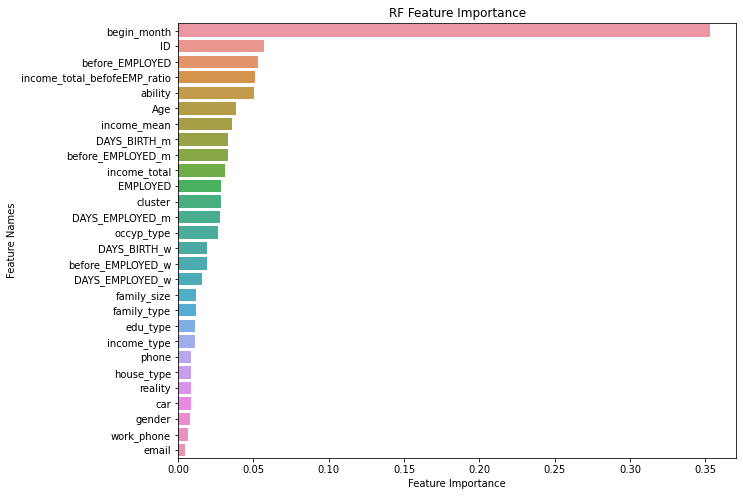

In [ ]:
plot_feature_importance(model_cat.feature_importances_,X_test.columns,'RF')